In [69]:
%cd /data/gunsbrother/prjs/ltvu/llms/GroundVQA/

from IPython.display import display

from pathlib import Path
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)

p_out_json = Path('analysis/VLG_OpenQA.json')
with p_out_json.open() as f:
    preds = json.load(f)
records = []
for pred in preds:
    pred_window = np.array(pred['pred_window'])
    record = {
        'clip_uid': pred['clip_uid'],
        'query_id': pred['query_id'],
        'query': pred['gt_window']['query'],
        'template': pred['gt_window']['template'],
        'iv_gt': np.array([pred['gt_window']['clip_start_sec'], pred['gt_window']['clip_end_sec']]),
        **{f'iv_pred{i}': pred_window[i, :-1] for i in range(pred_window.shape[0])},
        **{f'iou{i}': pred_window[i, -1] for i in range(pred_window.shape[0])},
        **{f'R@{k}/{thres:.1f}': pred_window[:k, -1].max() > thres for k in [1, 5] for thres in [.3, .5]},
        'answer': pred['gt_window'].get('answer', None),
    }
    records.append(record)
df = pd.DataFrame.from_records(records)
df.insert(df.columns.get_loc('iv_gt')+1, 'len_gt_sec', df['iv_gt'].apply(lambda x: x[1]-x[0]))
recall_cols = [col for col in df.columns if col.startswith('R@')]

# sanitizing data
df[df['template'].isin(['Objects: Where is object X?', 'Objects: Where is my object X?'])]
template_where_is_obj_src = ['Objects: Where is object X?', 'Objects: Where is my object X?']
template_where_is_obj_dst = 'Objects: Where is [object/my object] X?'
df.replace({
    'template': {src: template_where_is_obj_dst for src in template_where_is_obj_src}},
    inplace=True)

# Get max IoU cols from topk IoU cols
iou_cols = ['iou0', 'iou1', 'iou2', 'iou3', 'iou4']
max_iou_col = 'max_iou'
iou_top1_col = 'iou_topk_k=1'
max_iou_topk_col = 'max_iou_over_topks_k>1'
df[max_iou_col] = df[iou_cols].max(axis=1)
df[iou_top1_col] = df[iou_cols[0]]
df[max_iou_topk_col] = df[iou_cols[1:]].max(axis=1)
iou_stat_cols = [max_iou_col, iou_top1_col, max_iou_topk_col]

# Group by clip_uid and aggregate
df_clip_group = df.groupby('clip_uid')
num_clips = df['clip_uid'].nunique()
df_per_clip = df_clip_group.aggregate({col: 'mean' for col in iou_stat_cols})
df_per_clip = df_per_clip[df_clip_group.size() > 5]
df_per_clip = df_per_clip.sort_values(max_iou_col)
annotation = pd.read_csv('/data/gunsbrother/prjs/ltvu/tasks/Ego4D/EgoNLQ/csvs/nlq_val_v2.csv')
duration_sec = annotation.groupby('clip_uid').duration_sec.first()
df_per_clip['len_gt_sec'] = df_clip_group.agg({'len_gt_sec': 'mean'})
df_per_clip.columns = ['avg_'+col if col not in ['clip_uid'] else col for col in df_per_clip.columns]
df_per_clip['num_queries'] = df_clip_group.size()
df_per_clip = df_per_clip.reset_index()
df_per_clip.insert(1, 'len_clip_sec', df_per_clip['clip_uid'].map(duration_sec))
print(f'# clips: {num_clips} (total), {df_per_clip.shape[0]} (having >5 queries)')

# save to csv for further analysis
df.to_csv('analysis/VLG_OpenQA.csv', index=False)

display(df)
display(df_per_clip)

/data/gunsbrother/prjs/ltvu/llms/GroundVQA
# clips: 415 (total), 298 (having >5 queries)


,clip_uid,query_id,query,template,iv_gt,len_gt_sec,iv_pred0,iv_pred1,iv_pred2,iv_pred3,iv_pred4,iou0,iou1,iou2,iou3,iou4,R@1/0.3,R@1/0.5,R@5/0.3,R@5/0.5,answer,max_iou,iou_topk_k=1,max_iou_over_topks_k>1
0,cc2d7790-67f7-4e52-9fa9-33121c9431a2,95441b96-e2ef-4e61-b74f-10ebc2da5b4e_0,Where did i put the fire gun ?,Place: Where did I put X?,"[28.60389, 29.013]",0.40911,"[120.99176788330078, 122.8841323852539]","[28.04443359375, 29.668882369995117]","[3.4431443214416504, 8.809778213500977]","[65.28440856933594, 118.7636489868164]","[57.63841247558594, 59.403194427490234]",0.000000,0.251845,0.000000,0.000000,0.000000,False,False,False,False,None,0.251845,0.000000,0.251845
1,cc2d7790-67f7-4e52-9fa9-33121c9431a2,95441b96-e2ef-4e61-b74f-10ebc2da5b4e_1,Where was the drill machine ?,Objects: Where is [object/my object] X?,"[78.29272, 80.013]",1.72028,"[74.45758819580078, 79.52654266357422]","[458.6805725097656, 467.5257263183594]","[427.1209716796875, 438.6026306152344]","[400.41217041015625, 407.7094421386719]","[73.2210922241211, 78.21351623535156]",0.222094,0.000000,0.000000,0.000000,0.000000,False,False,False,False,None,0.222094,0.222094,0.000000
2,cc2d7790-67f7-4e52-9fa9-33121c9431a2,95441b96-e2ef-4e61-b74f-10ebc2da5b4e_2,Where did i put the screw driver?,Place: Where did I put X?,"[103.14923, 103.555]",0.40577,"[102.78418731689453, 104.0641860961914]","[254.00408935546875, 255.55198669433594]","[204.01455688476562, 205.7134246826172]","[102.53858947753906, 104.00569915771484]","[387.8180236816406, 390.1101379394531]",0.317008,0.000000,0.000000,0.276578,0.000000,True,False,True,False,None,0.317008,0.317008,0.276578
3,cc2d7790-67f7-4e52-9fa9-33121c9431a2,95441b96-e2ef-4e61-b74f-10ebc2da5b4e_3,How many cables did I drop on the table?,Objects: How many X’s? (quantity question),"[136.147, 137.204]",1.05700,"[125.12957000732422, 126.8093032836914]","[136.37242126464844, 137.9883575439453]","[124.88410949707031, 138.59413146972656]","[124.9743881225586, 128.33384704589844]","[134.15151977539062, 138.14886474609375]",0.000000,0.451612,0.077097,0.000000,0.264426,False,False,True,False,None,0.451612,0.000000,0.451612
4,cc2d7790-67f7-4e52-9fa9-33121c9431a2,95441b96-e2ef-4e61-b74f-10ebc2da5b4e_4,How many screw driver were on the table ?,Objects: How many X’s? (quantity question),"[191.78707, 192.464]",0.67693,"[384.0758361816406, 391.42413330078125]","[399.4351501464844, 408.02520751953125]","[7.943385124206543, 9.954809188842773]","[80.56350708007812, 104.98977661132812]","[386.1617736816406, 398.47698974609375]",0.000000,0.000000,0.000000,0.000000,0.000000,False,False,False,False,None,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4547,38a0d090-c67f-4197-b2a6-65cb56c356c5,b397c398-7482-44b7-9d04-9711f4e05e3d_3,what did I put in the plastic bag?,Objects: What did I put in X?,"[239.65683, 245.656]",5.99917,"[238.9487762451172, 243.74557495117188]","[241.84909057617188, 245.50198364257812]","[375.8798522949219, 377.69140625]","[236.8405303955078, 242.16038513183594]","[240.7530059814453, 245.5498046875]",0.609603,0.608900,0.000000,0.283996,0.799577,True,True,True,True,None,0.799577,0.609603,0.799577
4548,38a0d090-c67f-4197-b2a6-65cb56c356c5,b397c398-7482-44b7-9d04-9711f4e05e3d_4,what color was the hand towel I wiped my hand...,Objects: What X is Y?,"[292.33945, 297.339]",4.99955,"[210.1234588623047, 211.76490783691406]","[210.21595764160156, 211.97010803222656]","[381.37530517578125, 383.4420166015625]","[255.62539672851562, 257.33062744140625]","[209.3473358154297, 211.8690643310547]",0.000000,0.000000,0.000000,0.000000,0.000000,False,False,False,False,None,0.000000,0.000000,0.000000
4549,38a0d090-c67f-4197-b2a6-65cb56c356c5,b397c398-7482-44b7-9d04-9711f4e05e3d_5,What did I pick from the utensil holder?,Objects: What did I put in X?,"[303.84452, 304.844]",0.99948,"[259.59307861328125, 261.59600830078125]","[5.229187488555908, 8.860809326171875]","[302.8581848144531

,clip_uid,len_clip_sec,avg_max_iou,avg_iou_topk_k=1,avg_max_iou_over_topks_k>1,avg_len_gt_sec,num_queries
0,56f8ba1a-b63c-46d8-8a6f-d4c853c7af6a,480.000000,0.003055,0.000000,0.003055,1.314135,6
1,742355b3-3123-4671-99e9-8a4612204b9c,1200.033333,0.013940,0.000000,0.013940,10.214132,16
2,5ccb96c6-714f-4a93-9352-540899b27a4d,1199.966667,0.050399,0.029669,0.043731,11.981991,9
3,d2fd5fa0-1aaf-421f-9b0c-387950d55496,1200.000000,0.065693,0.018374,0.061956,1.366016,17
4,534d9bf8-bdc5-4236-8dba-dd7b894218d2,480.000000,0.069853,0.023291,0.046562,2.397495,11
...,...,...,...,...,...,...,...
293,b2e24b02-4d9e-436e-8557-fe02b75c9f5f,480.000000,0.653668,0.267437,0.597661,10.067787,12
294,ab094ea2-9251-4f10-945b-c2ab00c5282e,480.000000,0.674154,0.085035,0.672084,12.009887,8
295,e4cf448f-e442-4e19-bf87-1eee8fbf59d8,480.000000,0.682494,0.315494,0.554061,13.122802,18
296,7850166f-e4c2-4f4d-b95a-3fc223b8b747,480.000000,0.684704,0.563479,0.474920,3.461363,7


,example,size,portion,len_gt_sec,avg_max_iou,avg_iou_topk_k=1,avg_max_iou_over_topks_k>1,avg_R@1/0.3,avg_R@1/0.5,avg_R@5/0.3,avg_R@5/0.5
template,,,,,,,,,,,
Objects: Where is object X before / after event Y?,Where was the scissors before i picked it?,750,0.164763,6.955625,0.419222,0.255901,0.372262,0.409333,0.260000,0.636000,0.453333
Place: Where did I put X?,Where did i put the fire gun ?,725,0.159271,8.050061,0.357106,0.195926,0.304207,0.308966,0.172414,0.546207,0.353103
Objects: Where is [object/my object] X?,Where was the drill machine ?,624,0.137083,11.592101,0.207458,0.085924,0.162669,0.123397,0.089744,0.298077,0.197115
Objects: What did I put in X?,what did i put on the wall?,546,0.119947,10.992625,0.443124,0.240236,0.380206,0.347985,0.252747,0.637363,0.490842
Objects: How many X’s? (quantity question),How many cables did I drop on the table?,386,0.084798,15.536516,0.379193,0.235375,0.331136,0.326425,0.269430,0.531088,0.437824
Objects: In what location did I see object X ?,In what location did i last see the lighter?,359,0.078866,9.152771,0.230938,0.081160,0.198723,0.122563,0.077994,0.331476,0.233983
Objects: What X did I Y?,What item did i pick from the toolbox?,350,0.076889,14.749581,0.448756,0.258229,0.390980,0.397143,0.268571,0.668571,0.488571
Objects: What X is Y?,What color is the lightener i picked from the ...,332,0.072935,10.658682,0.286843,0.171366,0.235253,0.262048,0.162651,0.406627,0.283133
Objects: State of an object,Query Text:Did I leave the door open?,235,0.051626,8.153544,0.428906,0.256825,0.372023,0.382979,0.238298,0.612766,0.434043


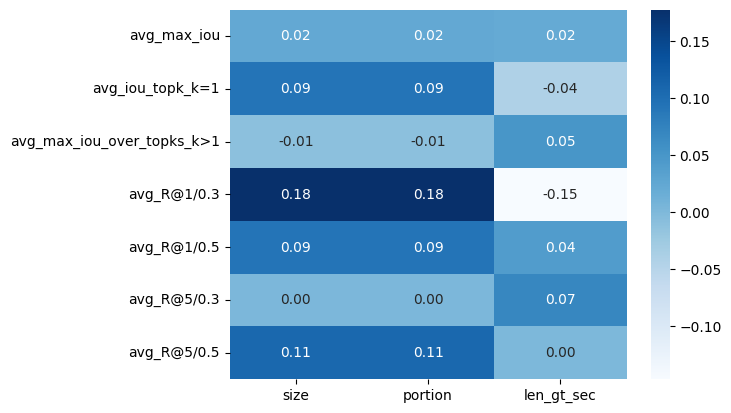

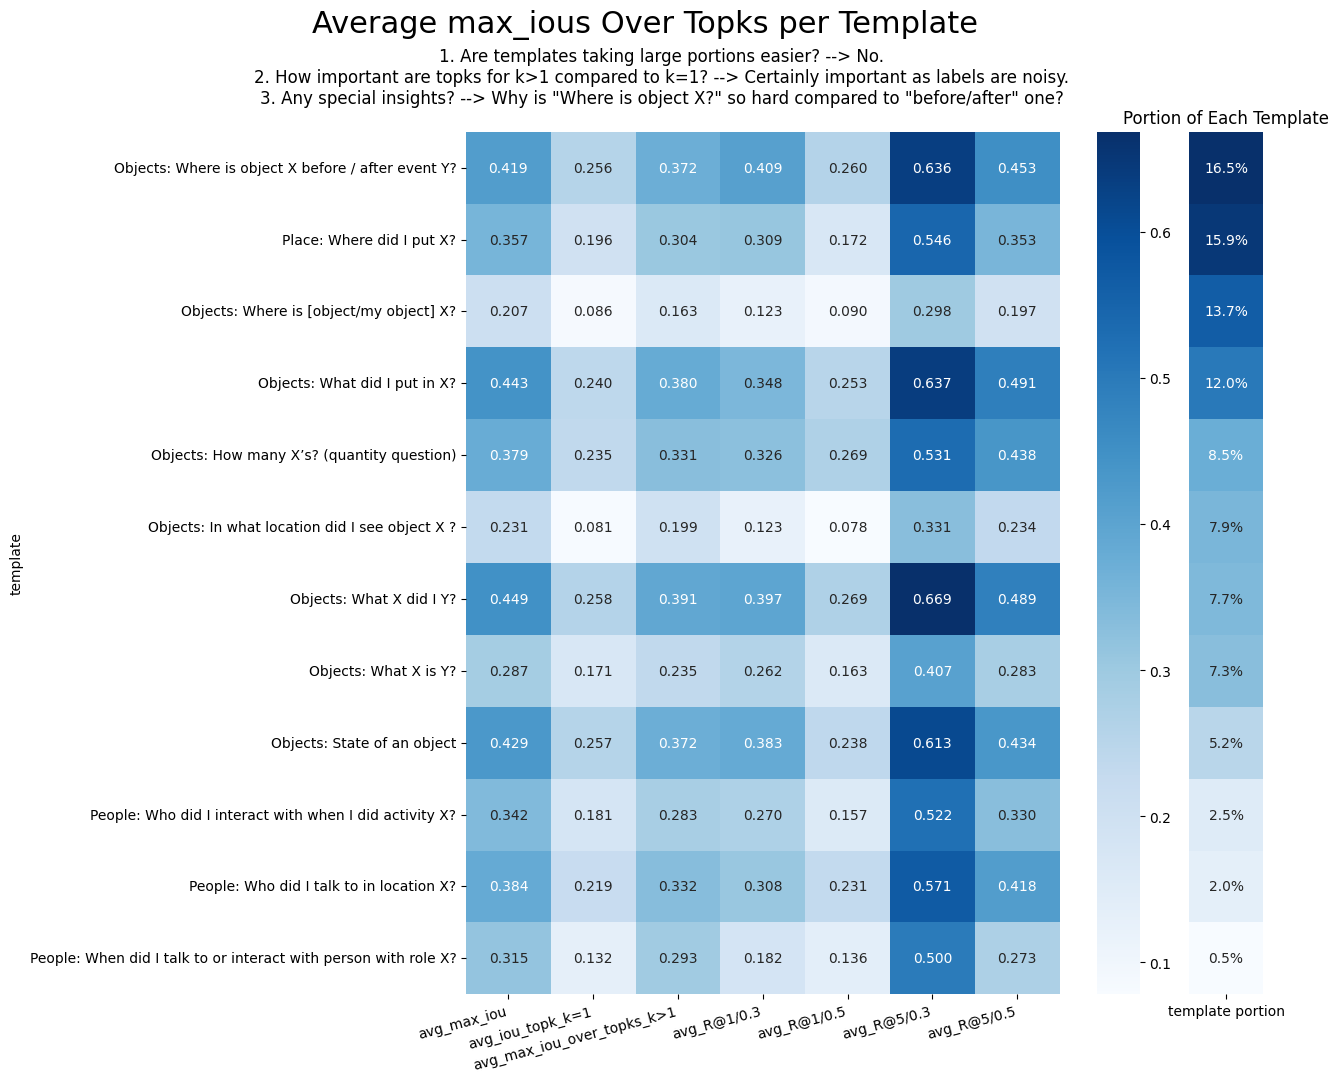

In [101]:
gobj_template = df.groupby('template')

df_per_template = gobj_template.aggregate({colname: 'mean' for colname in ['len_gt_sec'] + iou_stat_cols + recall_cols})
df_per_template.insert(0, 'example', gobj_template.query.first())
df_per_template.insert(1, 'size', gobj_template.size())
df_per_template.insert(2, 'portion', df_per_template['size'] / len(df))
df_per_template = df_per_template.sort_values('size', ascending=False)
df_per_template.columns = df_per_template.columns.map(lambda colname: f'avg_{colname}' if colname in iou_stat_cols + recall_cols else colname)
iou_stat_cols_per_template = [f'avg_{colname}' for colname in iou_stat_cols + recall_cols]
display(df_per_template)

sns.heatmap(df_per_template.iloc[:,1:].corr().iloc[3:, :3], annot=True, fmt='.2f', cmap='Blues')
plt.show()

fig, axs = plt.subplots(1, 2, figsize=(13, 11), width_ratios=[10, 1])
# sns heatmap of df_per_template except the column 'size'
ax = axs[0]
sns.heatmap(df_per_template[iou_stat_cols_per_template], annot=True, fmt='.3f', cmap='Blues', ax=ax, cbar=True)
ax.set_xticklabels(ax.get_xticklabels(), rotation=15, ha='right')
ax.set_title(
    '1. Are templates taking large portions easier? --> No.\n'
    '2. How important are topks for k>1 compared to k=1? --> Certainly important as labels are noisy.\n'
    '3. Any special insights? --> Why is "Where is object X?" so hard compared to "before/after" one?\n',
    ha='center', x=.33
)

ax = axs[1]
sns.heatmap(df_per_template['portion'].array[:, None], annot=True, fmt='.1%', cmap='Blues', ax=ax, cbar=False)
ax.set_title('Portion of Each Template')
ax.set_yticks([])
ax.set_xticklabels(['template portion'])
ax.set_yticklabels([])

plt.suptitle('Average max_ious Over Topks per Template', fontsize=22, ha='center')
plt.tight_layout()

plt.show()

# 어려운 '비디오' 찾기

- Query가 5개 이하인 비디오 제외

415


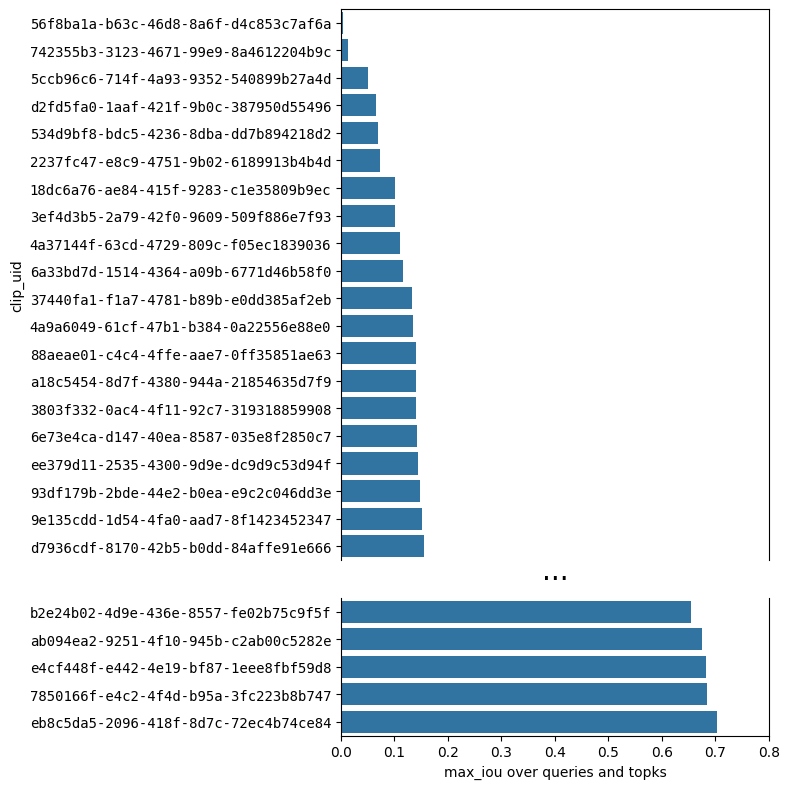

,clip_uid,len_clip_sec,avg_iou_topk_k=1,avg_max_iou_over_topks_k>1,avg_max_iou,avg_len_gt_sec,num_queries
0,56f8ba1a-b63c-46d8-8a6f-d4c853c7af6a,480.000000,0.000000,0.003055,0.003055,1.314135,6
1,742355b3-3123-4671-99e9-8a4612204b9c,1200.033333,0.000000,0.013940,0.013940,10.214132,16
2,5ccb96c6-714f-4a93-9352-540899b27a4d,1199.966667,0.029669,0.043731,0.050399,11.981991,9
3,d2fd5fa0-1aaf-421f-9b0c-387950d55496,1200.000000,0.018374,0.061956,0.065693,1.366016,17
4,534d9bf8-bdc5-4236-8dba-dd7b894218d2,480.000000,0.023291,0.046562,0.069853,2.397495,11
5,2237fc47-e8c9-4751-9b02-6189913b4b4d,480.000000,0.038345,0.072709,0.072709,212.940375,8
6,18dc6a76-ae84-415f-9283-c1e35809b9ec,480.000000,0.072349,0.101567,0.101567,3.723362,6
7,3ef4d3b5-2a79-42f0-9609-509f886e7f93,480.066667,0.073439,0.101668,0.101668,1.111167,6
8,4a37144f-63cd-4729-809c-f05ec1839036,1200.000000,0.000000,0.110419,0.110419,1.481498,6
9,6a33bd7d-1514-4364-a09b-6771d46b58f0,418.100000,0.028535,0.116400,0.116400,17.755599,7


In [49]:
from IPython.display import display, HTML
import subprocess


df_clip_group = df.groupby('clip_uid')
num_clips = df['clip_uid'].nunique()
print(num_clips)
df_per_clip = df_clip_group.aggregate({col: 'mean' for col in iou_stat_cols})
df_per_clip = df_per_clip[df_clip_group.size() > 5]
df_per_clip = df_per_clip.sort_values(max_iou_col)

fig, axs = plt.subplots(2, 1, figsize=(8, 8), height_ratios=[20, 5])

ax = axs[0]
sns.barplot(
    data=df_per_clip.head(20),
    y='clip_uid', x=max_iou_col, ax=ax)
ax.set_xlim(0, .8)
ax.set_xticklabels([])
ax.set_xticks([])
ax.set_xlabel('')
ax.spines['bottom'].set_visible(False)
# add "..." between two axes
ax.text(0.5, -.02, '...', fontsize=20, ha='center', va='center', transform=ax.transAxes)

ax = axs[1]
sns.barplot(data=df_per_clip.tail(5), y='clip_uid', x=max_iou_col, ax=ax)
ax.spines['top'].set_visible(False)
ax.set_xlim(0, .8)
ax.set_ylabel('')
ax.set_xlabel('max_iou over queries and topks')

for ax in axs:
    for label in ax.get_yticklabels():
        label.set_fontfamily('monospace')

plt.tight_layout()
plt.show()

annotation = pd.read_csv('/data/gunsbrother/prjs/ltvu/tasks/Ego4D/EgoNLQ/csvs/nlq_val_v2.csv')
duration_sec = annotation.groupby('clip_uid').duration_sec.first()
df_per_clip['len_gt_sec'] = df_clip_group.agg({'len_gt_sec': 'mean'})
df_per_clip.columns = ['avg_'+col if col not in ['clip_uid'] else col for col in df_per_clip.columns]
df_per_clip['num_queries'] = df_clip_group.size()
df_per_clip = df_per_clip.reset_index()
df_per_clip.insert(1, 'len_clip_sec', df_per_clip['clip_uid'].map(duration_sec))
display(HTML(df_per_clip.to_html()))

In [50]:
df_per_clip[['avg_max_iou', 'len_clip_sec', 'avg_len_gt_sec', 'num_queries']].corr().iloc[0]

avg_max_iou       1.000000
len_clip_sec     -0.323973
avg_len_gt_sec   -0.082716
num_queries      -0.021700
Name: avg_max_iou, dtype: float64

In [70]:
df_per_clip_moderate = df_per_clip[(df_per_clip['len_clip_sec'] < 500.) & (df_per_clip['avg_len_gt_sec'] < 25.)]
print(df_per_clip_moderate[['avg_max_iou', 'len_clip_sec', 'avg_len_gt_sec', 'num_queries']].corr().iloc[0])
df_per_clip_moderate

avg_max_iou       1.000000
len_clip_sec     -0.059491
avg_len_gt_sec    0.083381
num_queries       0.126528
Name: avg_max_iou, dtype: float64


,clip_uid,len_clip_sec,avg_iou_topk_k=1,avg_max_iou_over_topks_k>1,avg_max_iou,avg_len_gt_sec,num_queries,avg_max_iou_quarter
0,56f8ba1a-b63c-46d8-8a6f-d4c853c7af6a,480.000000,0.000000,0.003055,0.003055,1.314135,6,"(0.00205, 0.264]"
4,534d9bf8-bdc5-4236-8dba-dd7b894218d2,480.000000,0.023291,0.046562,0.069853,2.397495,11,"(0.00205, 0.264]"
6,18dc6a76-ae84-415f-9283-c1e35809b9ec,480.000000,0.072349,0.101567,0.101567,3.723362,6,"(0.00205, 0.264]"
7,3ef4d3b5-2a79-42f0-9609-509f886e7f93,480.066667,0.073439,0.101668,0.101668,1.111167,6,"(0.00205, 0.264]"
9,6a33bd7d-1514-4364-a09b-6771d46b58f0,418.100000,0.028535,0.116400,0.116400,17.755599,7,"(0.00205, 0.264]"
...,...,...,...,...,...,...,...,...
293,b2e24b02-4d9e-436e-8557-fe02b75c9f5f,480.000000,0.267437,0.597661,0.653668,10.067787,12,"(0.441, 0.703]"
294,ab094ea2-9251-4f10-945b-c2ab00c5282e,480.000000,0.085035,0.672084,0.674154,12.009887,8,"(0.441, 0.703]"
295,e4cf448f-e442-4e19-bf87-1eee8fbf59d8,480.000000,0.315494,0.554061,0.682494,13.122802,18,"(0.441, 0.703]"
296,7850166f-e4c2-4f4d-b95a-3fc223b8b747,480.000000,0.563479,0.474920,0.684704,3.461363,7,"(0.441, 0.703]"


In [ ]:
# mean len_clip_sec of the first and the last quarter w.r.t avg_max_iou
df_per_clip['avg_max_iou_quarter'] = pd.qcut(df_per_clip['avg_max_iou'], 4)
df_per_clip.groupby('avg_max_iou_quarter', observed=True).agg({'len_clip_sec': 'mean'})

,len_clip_sec
avg_max_iou_quarter,
"(0.00205, 0.264]",624.164000
"(0.264, 0.356]",500.914414
"(0.356, 0.441]",487.856306
"(0.441, 0.703]",473.932889


---

### 짧아도 잘 맞추는 건 뭐지?

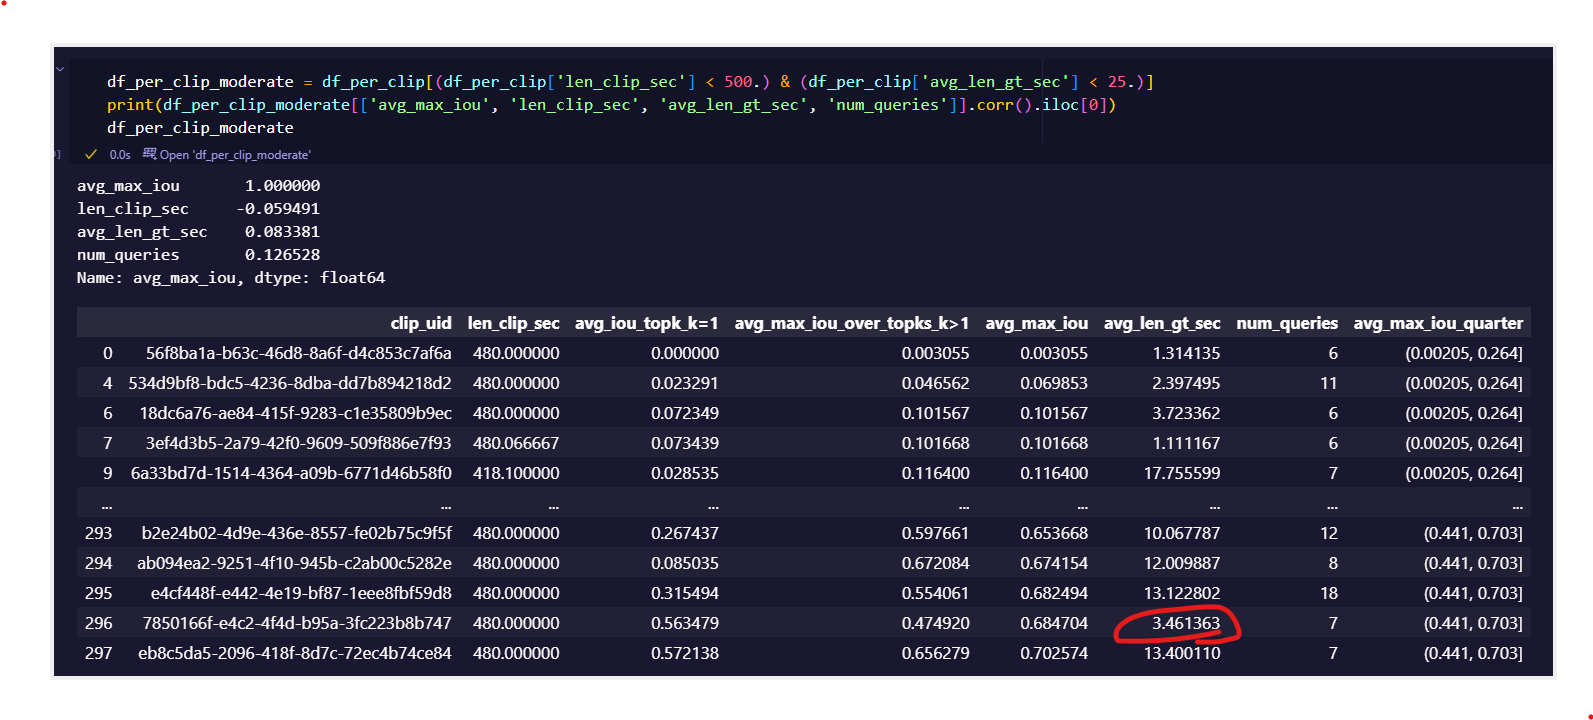


#### 저 비디오는 쉬운 질문들이 많은가? 

---

In [103]:
df_per_template

,example,size,portion,len_gt_sec,avg_max_iou,avg_iou_topk_k=1,avg_max_iou_over_topks_k>1,avg_R@1/0.3,avg_R@1/0.5,avg_R@5/0.3,avg_R@5/0.5
template,,,,,,,,,,,
Objects: Where is object X before / after event Y?,Where was the scissors before i picked it?,750,0.164763,6.955625,0.419222,0.255901,0.372262,0.409333,0.260000,0.636000,0.453333
Place: Where did I put X?,Where did i put the fire gun ?,725,0.159271,8.050061,0.357106,0.195926,0.304207,0.308966,0.172414,0.546207,0.353103
Objects: Where is [object/my object] X?,Where was the drill machine ?,624,0.137083,11.592101,0.207458,0.085924,0.162669,0.123397,0.089744,0.298077,0.197115
Objects: What did I put in X?,what did i put on the wall?,546,0.119947,10.992625,0.443124,0.240236,0.380206,0.347985,0.252747,0.637363,0.490842
Objects: How many X’s? (quantity question),How many cables did I drop on the table?,386,0.084798,15.536516,0.379193,0.235375,0.331136,0.326425,0.269430,0.531088,0.437824
Objects: In what location did I see object X ?,In what location did i last see the lighter?,359,0.078866,9.152771,0.230938,0.081160,0.198723,0.122563,0.077994,0.331476,0.233983
Objects: What X did I Y?,What item did i pick from the toolbox?,350,0.076889,14.749581,0.448756,0.258229,0.390980,0.397143,0.268571,0.668571,0.488571
Objects: What X is Y?,What color is the lightener i picked from the ...,332,0.072935,10.658682,0.286843,0.171366,0.235253,0.262048,0.162651,0.406627,0.283133
Objects: State of an object,Query Text:Did I leave the door open?,235,0.051626,8.153544,0.428906,0.256825,0.372023,0.382979,0.238298,0.612766,0.434043
